In [143]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [144]:
def filter(s):
    out = []
    s = s.strip()
    for i,char in enumerate(s):
        if i > 0 and char != ' ':
            if (not s[i-1].isalpha()) and char.isalpha():
                out.append(' ' +  char)
            elif char in set('.,?!') : out.append(' ' + char)
            else: out.append(char)
        elif char != ' ': out.append(char)
    return ''.join(out)

def read_data_fra(num_examples=None):
  with open('/kaggle/input/fra-txt/fra.txt') as f:
      # 替换字符
      source_txt = f.read().replace('\u202f', ' ').replace('\xa0', ' ').lower()
      lines = source_txt.split('\n') # 切分单个数据
      # 每个词元前后添加空格
      lines = [filter(line) for line in lines]
      source, target = [], []
      for i, line in enumerate(lines):
          # 自定义数量
          if num_examples and i > num_examples:
              break
          part = line.split('\t')
          if len(part) == 2:
              source.append(part[0].strip().split(' '))
              target.append(part[1].strip().split(' '))
      return source, target


source, target = read_data_fra()
print( source[:5])
print( target[:5])


[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?']]
[['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?']]


In [145]:
def filter(s):
    out = []
    s = s.strip()
    for i,char in enumerate(s):
        if i > 0 and char != ' ':
            if (not s[i-1].isalpha()) and char.isalpha():
                out.append(' ' +  char)
            elif char in set('.,?!') : out.append(' ' + char)
            else: out.append(char)
        elif char != ' ': out.append(char)
    return ''.join(out)
    return out

filter(' go away.!   \t e ')

'go away . !\t e'

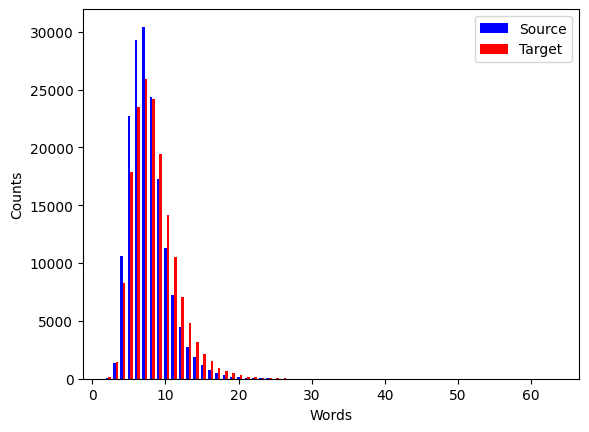

In [146]:
import matplotlib.pyplot as plt
from collections import Counter

source_counts = Counter([len(sentence) for sentence in source])
target_counts = Counter([len(sentence) for sentence in target])

# 计算每个柱子的宽度
width = 0.35

# 绘制直方图
plt.bar(source_counts.keys(), source_counts.values(), width=width, color='blue', label='Source')
plt.bar([x + width for x in target_counts.keys()], target_counts.values(), width=width, color='red', label='Target')

# 添加图例和标签
plt.legend()
plt.xlabel('Words')
plt.ylabel('Counts')

# 显示图形
plt.show()


In [147]:
import collections

def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将2D词元列表展平成一个1D列表
        tokens = [token for line in tokens for token in line]
    # 使用collections.Counter统计词元的频率
    return collections.Counter(tokens)

class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # 如果没有提供词元列表，则使用空列表
        if tokens is None:
            tokens = []
        # 如果没有提供保留词元列表，则使用空列表
        if reserved_tokens is None:
            reserved_tokens = []
        # 统计词元的频率并按频率降序排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 初始化词表，未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 创建从词元到索引的映射字典
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        # 遍历按频率排序后的词元和对应频率
        for token, freq in self._token_freqs:
            # 如果词元的频率小于最小频率，则停止添加
            if freq < min_freq:
                break
            # 如果词元不在词表中，则将其添加到词表并更新映射字典
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        # 返回词表的长度
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 如果输入的是单个词元，返回其对应的索引
        if not isinstance(tokens, (list, tuple)): #不是列表或元组
            return self.token_to_idx.get(tokens, self.unk) # 字典中不存则自动返回unk
        # 如果输入的是一个词元列表，递归获取每个词元的索引
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        # 如果输入的是单个索引，返回其对应的词元
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        # 如果输入的是一个索引列表，递归获取每个索引对应的词元
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        # 返回未知词元的索引
        return 0

    @property
    def token_freqs(self):
        # 返回词元及其对应频率的列表
        return self._token_freqs

# 将出现次数少于2的词元过滤为unk
# 引入填充词元<pad> 开始词元 结束词元
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)


9983

In [148]:
def truncate_pad(src, padding_token, num_steps):
    # 超过长度则截断
    if (len(src) > num_steps): return src[:num_steps]

    # 长度不足 则补充<pad>
    return src + [padding_token] * (num_steps - len(src))

truncate_pad(src_vocab[source[0]], src_vocab['<pad>'], 10)


[51, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [149]:
def build_array(tokens, vocab, num_steps):
    # 将词元列表转换为索引列表
    tokens = [vocab[token] for token in tokens]
    # 每个序列最后添加一个eos
    tokens = [token + [vocab['<eos>']] for token in tokens]

    # 将处理后的定长序列构造为张量
    array = torch.tensor([
        truncate_pad(token, vocab['<pad>'], num_steps)
        for token in tokens
    ], dtype=torch.long)

    # 统计非pad的词元数量
    valid_len = (array != vocab['<pad>'] ).type(torch.int32).sum(1)
    return array, valid_len

In [150]:
class fraDataset(Dataset):
    def __init__(self, src_array, src_valid_len, tgt_array, tgt_valid_len):
        self.src_array = src_array
        self.src_valid_len = src_valid_len
        self.tgt_array = tgt_array
        self.tgt_valid_len = tgt_valid_len

    def __len__(self):
        return len(self.src_array)

    def __getitem__(self, idx):
        X = self.src_array[idx]
        X_valid_len = self.src_valid_len[idx]
        Y = self.tgt_array[idx]
        Y_valid_len = self.tgt_valid_len[idx]

        return X, X_valid_len, Y, Y_valid_len

In [151]:
def load_data(batch_size, num_steps, num_examples=600):
    source, target = read_data_fra(num_examples)

    # 构造词表
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # 构造训练数据
    src_array, src_valid_len = build_array(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, num_steps)

    print( src_array.shape , tgt_array.shape )
    print( src_valid_len.shape , tgt_valid_len.shape )
    # 构造数据迭代器
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = fraDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=True, num_workers=2), src_vocab, tgt_vocab

# train_iter, src_vocab, tgt_vocab = load_data(batch_size=2, num_steps=8)



In [152]:
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break  # 只打印第一个批次的内容


X: tensor([[ 19,  24,   4,   3,   1,   1,   1,   1,   1,   1],
        [  6,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 18, 176,   4,   3,   1,   1,   1,   1,   1,   1],
        [169,  16,   5,   3,   1,   1,   1,   1,   1,   1],
        [  7,   8, 158,   4,   3,   1,   1,   1,   1,   1],
        [ 15,  29,   4,   3,   1,   1,   1,   1,   1,   1],
        [  6,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 28,  34,   5,   3,   1,   1,   1,   1,   1,   1],
        [  7,   8, 156,   4,   3,   1,   1,   1,   1,   1],
        [ 14,  27,   5,   3,   1,   1,   1,   1,   1,   1],
        [  0,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 19, 126,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 93,  21,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 71,   9,   4,   3,   1,   1,   1,   1,   1,   1],
        [121,  58,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 54,  55, 179,   4,   3,   1,   1,   1,   1,   1],
        [  7,   8,   0,   4,   3,   1

In [153]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError


class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [154]:
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):

        # X形状：(batch_size,num_steps)
        X = self.embedding(X)

        # X形状：(batch_size,num_steps,embed_size)
        # 变换(num_steps,batch_size,embed_size)
        X = X.permute(1, 0, 2)

        # 获取隐状态
        output, state = self.rnn(X)
        # output = (num_steps, batch_size, num_hiddens)
        # state = (num_laters, batch_size, num_hiddens)
        return output, state

In [155]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4,7), dtype=torch.long)
output,state = encoder(X)
print(output.shape, state.shape)

torch.Size([7, 4, 16]) torch.Size([2, 4, 16])


In [156]:
state[-1].shape

torch.Size([4, 16])

In [157]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 需要同时接受 X 和 state 进行拼接 见forward
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)

        # 输出层 全连接
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def forward(self, X, state):

        X = self.embedding(X).permute(1, 0, 2)

        # state = (num_layers, batch_size, num_hiddens)
        # 取state中 由最后一层的所有节点产生的输出
        # 第一维重复num_steps次 第二、三维重复1次
        # context = (num_steps, batch_size, num_hiddens)
        context = state[-1].repeat(X.shape[0], 1, 1)

        # 组合X和context 在最后一个维度进行连接
        # -> (batch_size,num_steps,embed_size + num_hiddens)
        X_and_context = torch.cat((X, context), 2)

        output, state = self.rnn(X_and_context, state)

        # 预测输出 调整为batch_size在前的模式
        output = self.dense(output).permute(1, 0, 2)

        return output, state

In [158]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [159]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        output,state = self.encoder(enc_X)
        return self.decoder(dec_X, state)
                            

encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
seq2seq = EncoderDecoder(encoder,decoder)         
X = torch.zeros((4,7), dtype=torch.long)
output, state = seq2seq(X,X)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [160]:
def sequence_mask(X, valid_len, value=0):

    maxlen = X.size(1) # 取出定长序列的长度 size(0)是batch_size

    # 生成一个从 0 到 maxlen-1 的一维张量 [0,1,2,3...,maxlen-1]

    # torch.arrange()[None, :] -> 将[0,1,2,3...,maxlen-1]变成[[0,1,2,3...,maxlen-1]]
    # 即：(maxlen)-> (1,maxlen) 准备后续的广播机制

    # valid_len[:, None] -> 将(batch_size)变成(batch_size,1)

    # 比较[0, 1, 2, 3, 4] 和 [3,4]
    # 通过广播机制：
    '''
    [[0, 1, 2, 3, 4]
    [0, 1, 2, 3, 4]]

    与
    [[3,3,3,3,3]
    [4,4,4,4,4]] 进行比较

    故得到：
    [True,  True,  True,  False,  False],
    [True,  True,  True,  True,  False]]
    '''
    mask = torch.arange(maxlen, dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]

    X[~mask] = value # False对应位置进行修改
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [161]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        # label: (batch_size, seq_len)
        # pred: (batch_size, seq_len, num_classes)
        weights = torch.ones_like(label) # 默认保留所有值
        weights = sequence_mask(weights, valid_len) # 超出合法长度的权值为0
        self.reduction = 'none' # 确保得到与输入相同形状的损失张量

        # pred转换为 (batch_size, num_classes, seq_len) 符合pytorch接口
        # unweighted_loss为(batch_size, seq_len)
        unweighted_loss = super().forward(pred.permute(0, 2, 1), label)

        # 乘以权值 算均值
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [162]:
def grad_clipping(net, theta):
    params = [p for p in net.parameters() if p.requires_grad] # 取出所有需要优化的参数
    # 求出L2范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 若超过theta 进行梯度裁剪
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [163]:
import time

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型。"""

    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    
    net.train()
    st = time.time()
    epoch_losses = []  # 用于存储每轮的损失
    
    for epoch in range(num_epochs):

        sum_loss, sum_tokens = 0.0, 0.0
        
        for X, X_valid_len, Y, Y_valid_len in data_iter:
            X, X_valid_len, Y, Y_valid_len = X.to(device), X_valid_len.to(device), Y.to(device), Y_valid_len.to(device)
            
#             print('ok')
#             print(X.shape, Y.shape)
            
            # 取出-> [ tgt_vocab['<bos>'] ]
            # 在列表中重复batch_size次 -> [ bos, bos, bos, ... ]
            # reshape -> [ [bos], [bos], [bos], ... ] # 每个bos占一个维度
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            
            # decoder_X的输入要去掉最后一个eos 每个输入前加一个bos
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1) # 梯度裁剪
            
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                sum_loss += l.sum()
                sum_tokens += num_tokens

        avg_loss = (sum_loss / sum_tokens).item()
        epoch_losses.append(avg_loss)  # 记录每轮的平均损失

        if (epoch + 1) % 10 == 0:
            print(f'epoch{epoch + 1}/{num_epochs}, loss = {avg_loss}')
        
    plt.plot(range(1, num_epochs + 1), epoch_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()
            
    print(f'loss {sum_loss.item() / sum_tokens.item():.3f}, {sum_tokens.item() / (time.time()-st):.1f} '
          f'tokens/sec on {str(device)}')


In [164]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [165]:
train_iter, src_vocab, tgt_vocab = load_data(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

torch.Size([601, 10]) torch.Size([601, 10])
torch.Size([601]) torch.Size([601])


epoch10/300, loss = 0.22763317823410034
epoch20/300, loss = 0.15561436116695404
epoch30/300, loss = 0.11084903031587601
epoch40/300, loss = 0.08042813092470169
epoch50/300, loss = 0.06124052032828331
epoch60/300, loss = 0.049532413482666016
epoch70/300, loss = 0.04249805584549904
epoch80/300, loss = 0.03689628466963768
epoch90/300, loss = 0.031948383897542953
epoch100/300, loss = 0.02906380221247673
epoch110/300, loss = 0.027234962210059166
epoch120/300, loss = 0.024834780022501945
epoch130/300, loss = 0.025023696944117546
epoch140/300, loss = 0.02344653196632862
epoch150/300, loss = 0.022753022611141205
epoch160/300, loss = 0.021878015249967575
epoch170/300, loss = 0.021361684426665306
epoch180/300, loss = 0.02137690968811512
epoch190/300, loss = 0.02114427648484707
epoch200/300, loss = 0.021064719185233116
epoch210/300, loss = 0.020834797993302345
epoch220/300, loss = 0.019905392080545425
epoch230/300, loss = 0.0200700294226408
epoch240/300, loss = 0.019976964220404625
epoch250/300, 

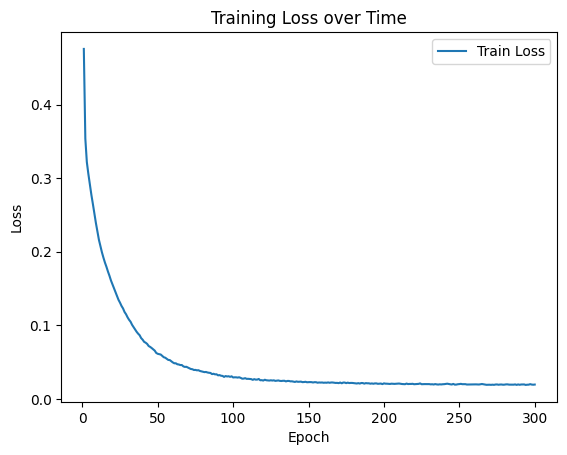

loss 0.019, 45.6 tokens/sec on cuda


In [166]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [170]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    
    net.eval()
    
   # 对测试数据需要进行相同的预处理

   # 对源句子进行分词，并将其转换为对应的词汇表索引
   # 在句子末尾添加结束标记 `<eos>`
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    
    # 有效长度
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
   
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 添加一个批次维度
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    # encoder
    _,dec_state = net.encoder(enc_X)

    # decoder初始输入 设置为 `<bos>` 标记
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0
    )
    
    # 输出序列
    output_seq = []
    
    # 执行num_steps次
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
  		# 最大值的索引作为预测结果
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        # 如果预测到结束标记 `<eos>`，停止解码
        if pred == tgt_vocab['<eos>']: break
        
        # 将当前预测的词汇索引加入输出序列
        output_seq.append(pred)
    
    # 返回真实文本
    return ' '.join(tgt_vocab.to_tokens(output_seq))

print('yes')

yes


In [171]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}')

go . => vas- !
i lost . => suis- je
he's calm . => !
i'm home . => !
